## Load the dataset

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

**Note: Download of ETF prices and preprocessing steps can be omitted if csv file available in repository is imported locally**

In [ ]:
# Download ETF daily prices from Yahoo Finance 
tickers = ['VTI','IUSV','VBR','VEA','VWO','SHV','STIP','AGG','IBND','EMB']
my_data=pd.DataFrame()
for t in tickers: 
    my_data[t]=yf.download(t, end='2021-07-24')['Adj Close']

## Data pre-processing

In [3]:
# Inspect first rows
my_data.head()

,VTI,IUSV,VBR,VEA,VWO,SHV,STIP,AGG,IBND,EMB
Date,,,,,,,,,,
2001-06-15,37.115849,14.996559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-18,36.879147,14.954364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-19,36.982494,15.004597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-20,37.372540,15.103045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-21,37.672611,15.062857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The raw dataset starts in 2001. However, not all ETFs were launched at that time so that there are missing values. 

In [4]:
# Inspect missing values
my_data.isna().sum()

VTI        0
IUSV       0
VBR      657
VEA     1534
VWO      936
SHV     1399
STIP    2381
AGG      572
IBND    2244
EMB     1636
dtype: int64

In [5]:
# Dropping missing values
my_data = my_data.dropna()
my_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2677 entries, 2010-12-03 to 2021-07-23
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VTI     2677 non-null   float64
 1   IUSV    2677 non-null   float64
 2   VBR     2677 non-null   float64
 3   VEA     2677 non-null   float64
 4   VWO     2677 non-null   float64
 5   SHV     2677 non-null   float64
 6   STIP    2677 non-null   float64
 7   AGG     2677 non-null   float64
 8   IBND    2677 non-null   float64
 9   EMB     2677 non-null   float64
dtypes: float64(10)
memory usage: 230.1 KB


<br> 

After dropping missing values, price data ranges from December 2010 to July 2021, which is considered sufficient for this project.   
Each column consists of one variable (one ETF), each row of one observation (daily prices) and each cell contains one value. Thus, data is in desirable format for further analysis. 

## Mean_variance optimization

**Baseline model: Markowitz optimization portfolio (Modern Portfolio Theory)** 


- The model solves a convex optimization problem: It takes as input the expected ETF returns approximated by past average annual returns as well as the annualized covariance matrix. It outputs the weights to be invested in each ETF to maximize the return per unit of risk (= Sharpe ratio).


- *Initial optimal weights:* Returns between January 2011 and December 2014 are initially used to get optimal weights that maximize Sharpe ratio. 

- *Monthly rebalancing:* Window of returns used to get optimal weights is gradually expanded by one month, e.g. January 2011 - January 2015 returns used to get optimal weights for February 2015 and so on.  
*Note: This allows to approximate walk-forward validation used to train AI algorithms. Also, MVO outputs are then equal to outputs of AI optimization, namely monthly optimal weights.*

- Thus, it is assumed that the investor starts investing January 1st, 2015, monthly rebalances portfolio weights and the final rebalancing happens in the beginning of July 2021. 

In [74]:
# Get monthly weights that maximize Sharpe ratio between January 2015 and June 2021
start_year = '2011'
monthly_index = pd.period_range('2014-12','2021-05', freq='M')
optimal_monthly_weights = []
new_index = []

for month in monthly_index:
    end_month = str(month)
    ef = EfficientFrontier(my_data[start_year:end_month].pct_change().mean()*252,\
                               my_data[start_year:end_month].pct_change().cov()*252)

    ef.add_constraint(lambda x : x >= 0) # weights all >= 0 (no short-selling)
    raw_weights_sharpe = ef.max_sharpe()
    cleaned_weights_sharpe = ef.clean_weights() # reformat weights 
    optimal_monthly_weights.append(cleaned_weights_sharpe)
    new_index.append(month+1)

In [75]:
# Store optimal weights in dataframe
MVO_monthly_weights = pd.DataFrame(optimal_monthly_weights, index=new_index)
MVO_monthly_weights

,VTI,IUSV,VBR,VEA,VWO,SHV,STIP,AGG,IBND,EMB
2015-01,0.17170,0.02716,0.0,0.0,0.0,0.0,0.0,0.80114,0.0,0.0
2015-02,0.17701,0.00000,0.0,0.0,0.0,0.0,0.0,0.82299,0.0,0.0
2015-03,0.19694,0.00000,0.0,0.0,0.0,0.0,0.0,0.80306,0.0,0.0
2015-04,0.19763,0.00000,0.0,0.0,0.0,0.0,0.0,0.80237,0.0,0.0
2015-05,0.20451,0.00000,0.0,0.0,0.0,0.0,0.0,0.79549,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-02,0.25625,0.00000,0.0,0.0,0.0,0.0,0.0,0.74375,0.0,0.0
2021-03,0.27881,0.00000,0.0,0.0,0.0,0.0,0.0,0.72119,0.0,0.0
2021-04,0.29907,0.00000,0.0,0.0,0.0,0.0,0.0,0.70093,0.0,0.0
2021-05,0.29911,0.00000,0.0,0.0,0.0,0.0,0.0,0.70089,0.0,0.0


In [11]:
type(my_data)

pandas.core.frame.DataFrame

In [24]:
def get_daily_portfolio_returns(daily_asset_returns, monthly_predicted_weights,
                                period = pd.period_range('2015-01','2021-06', freq='M')):
    '''Takes daily asset returns and asset weights to calculate daily portfolio returns.
        Asset weights are rebalanced monthly and must be specified for each month. 
        
        Parameters
        ----------
        daily_asset_returns : pandas.DataFrame
            Daily asset returns. 
        monthly_predicted_weights : pandas.DataFrame
            Asset weights for each month.
        period : pandas.PeriodIndex
            Months for which portfolio returns are calculated (YYYY-MM). 
        
        Returns
        ----------
        daily_returns : pandas.DataFrame
            Daily portfolio returns given asset weights over specified period. 
    '''
    daily_returns = pd.Series()
    for month in period:
        month = str(month)
        daily_returns = daily_returns.append(daily_asset_returns.loc[month] @ monthly_predicted_weights.loc[month])
    return daily_returns

In [25]:
def performance_metrics(daily_returns):
    '''Calculates total return, annualized return, annualized volatility and sharpe ratio given daily asset returns.
    
    Parameters
    ----------
    daily_returns : pandas.DataFrame
        Daily asset returns. 
    
    Returns
    ----------
    total_return, annualized_return, annualized_vol, sharpe_ratio : float 
    
    '''
    cumul_return = (1+daily_returns).cumprod()
    total_return = np.round((cumul_return[-1]-1) * 100,2)
    delta = daily_returns.index[-1] - daily_returns.index[0] #get holding period
    annualized_return = np.round(((1+total_return/100)**(365/delta.days)-1)*100,2)
    annualized_vol = np.round(daily_returns.std()*np.sqrt(252)*100,2)
    sharpe_ratio = np.round((annualized_return-2)/annualized_vol,2) #risk-free rate: 2%
    return total_return, annualized_return, annualized_vol, sharpe_ratio


In [76]:
# Compute daily portfolio returns with monthly rebalancing 
daily_returns = my_data['2015-01':].pct_change().dropna()
daily_returns_MVO = get_daily_portfolio_returns(daily_returns,MVO_monthly_weights)

In [77]:
# Save metrics in dataframe 
performance = performance_metrics(daily_returns_MVO)
results = pd.DataFrame(performance, index=['Total return','Annualized return',\
                                           'Annualized volatility','Sharpe ratio'], columns=['MVO'])
results

,MVO
Total return,44.57
Annualized return,5.85
Annualized volatility,5.49
Sharpe ratio,0.70


## Machine learning optimization

- MPT has a number of drawbacks, f.ex. input sensitivity meaning that a small change in inputs leads to a change in portfolio allocation; sample estimates of risk using variance (only considers downside risk) and of return using sample mean leads to noisy estimates (high range of numbers) and overly concentrated portfolios. 


- Proposition: Use a range of features (e.g. technical analysis tools + more robust estimators of return such as CAPM returns and alternative measures of risk (e.g. VaR, CVaR) to predict monthly optimal portfolio weights that maximize Sharpe ratio.


- For each month, the optimal Sharpe ratio portfolio weights will be determined and used to train the model. Regression trees are used to predict the optimal weights that will be used to monthly rebalance the portfolio. 


### Dependent variables: Monthly optimal Sharpe ratio weights

For each month, we want to get the portfolio weights of the optimal Sharpe ratio portfolio. The pyportfolio opt library does only work with annualized and not monthly data. Hence, the optimal portfolios will be manually calculated by generating a set of random portfolios and selecting the maximum Sharpe ratio portfolio for each month.

In [11]:
# Get ex-post covariance matrix for each month (using daily returns of respective month):
daily_return_i = daily_returns.index
entire_monthly_index = pd.period_range('2011-01','2021-07', freq='M')
covariances = {}
for i in entire_monthly_index: 
    mask = (daily_return_i.month == i.month) & (daily_return_i.year == i.year)
    covariances[i] = daily_returns[mask].cov()

In [12]:
# Compute monthly returns 
monthly_data = my_data.asfreq('BM').ffill()
monthly_ret = (monthly_data/monthly_data.shift(1) -1).dropna()
# Add return for July 2021 (not considered above as dataframe ends before end of July)
monthly_ret = monthly_ret.append(my_data['2021-07'].iloc[-1]/my_data['2021-06'].iloc[-1] -1,ignore_index=True)
# Use index of covariances for consistency
monthly_ret.index = sorted(covariances.keys())

In [13]:
# Generate 1000 random portfolios per month and calculate returns + volatility for each portfolio
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}
np.random.seed(1)

for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(10):
        weights = np.random.random(10)
        weights /= np.sum(weights) 
        returns = np.dot(weights, monthly_ret.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)

In [14]:
# Loop through each month to calculate sharpe ratio of each portfolio
sharpe_ratio, max_sharpe_idxs = {}, {}

for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each month
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

In [15]:
# Loop through each month to select the portfolio with the highest Sharpe ratio
targets = []

for date in portfolio_weights.keys():

   
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx]) # Append the monthly maximum Sharpe ratio portfolio 
                                                        # to target list.


In [16]:
# As features use price data starting January 2011, Y should start February 2011
Y = pd.DataFrame(targets, columns = monthly_data.columns, index=monthly_ret.index)
Y.drop(['2011-01'], axis=0, inplace=True)
Y

,VTI,IUSV,VBR,VEA,VWO,SHV,STIP,AGG,IBND,EMB
2011-02,0.052161,0.084164,0.141473,0.057051,0.145080,0.099542,0.002526,0.148418,0.110327,0.159259
2011-03,0.136937,0.080224,0.131955,0.092461,0.056207,0.070040,0.087092,0.079200,0.133479,0.132406
2011-04,0.160841,0.173343,0.136385,0.112825,0.031891,0.092496,0.068384,0.044584,0.117385,0.061865
2011-05,0.195156,0.163531,0.006575,0.144294,0.094585,0.192738,0.045041,0.054324,0.016572,0.087184
2011-06,0.023215,0.060321,0.083426,0.046378,0.161104,0.109753,0.216635,0.049128,0.186257,0.063783
...,...,...,...,...,...,...,...,...,...,...
2021-03,0.122258,0.136455,0.122208,0.137415,0.061551,0.065294,0.101284,0.135112,0.026303,0.092122
2021-04,0.074420,0.174036,0.074925,0.000259,0.109390,0.019586,0.142426,0.206081,0.184377,0.014501
2021-05,0.053461,0.071149,0.091495,0.120706,0.054371,0.110221,0.142258,0.071858,0.170788,0.113692
2021-06,0.097432,0.060557,0.101891,0.194525,0.145841,0.076324,0.131512,0.131851,0.001115,0.058951


### Independent variables

In [17]:
# Import features (make sure csv files are in same working directory)
feature_names=['RSI','EWMA','CAPM','Fama-French','VaR','CVaR','Trimmed Mean']
path_name=['RSI.csv','EWMA.csv','CAPM_returns.csv','Fama_French_returns.csv'\
          ,'Value_at_risk.csv','Cond_Value_at_risk.csv','Trimmed_mean.csv']

i=0
features = {}
for name in feature_names: 
    
    path = path_name[i]
    features[name]=pd.read_csv(path, index_col=[0])
    i+=1
    


In [18]:
# Merge features in a dataframe (X matrix)
X= pd.concat(features, axis=1)
X

RSI                                                         \
               VTI       IUSV        VBR        VEA        VWO        SHV   
2011-01  50.160415  50.345952  49.667940  51.135190  50.774697  50.000000   
2011-02  51.413543  51.601421  50.726199  51.040874  52.702374  50.001348   
2011-03  49.083832  48.781377  49.502151  48.128038  49.874067  49.210906   
2011-04  47.649244  46.871724  49.191585  45.534533  49.061523  51.613871   
2011-05  51.375317  51.283773  50.438114  53.138948  51.946504  50.387712   
...            ...        ...        ...        ...        ...        ...   
2021-02  49.232993  48.266662  50.448908  47.934277  47.964093  51.999427   
2021-03  50.963825  48.998040  50.346162  50.599428  50.151249  50.000000   
2021-04  52.081216  49.808131  50.418071  49.305759  50.109656  50.000000   
2021-05  52.081216  49.808131  50.418071  49.305759  50.109656  50.000000   
2021-06  52.142198  53.074338  52.394377  47.761120  46.332080  50.000000   

                                                     ... Trimmed Mean  \
              STIP        AGG       IBND        EMB  ...          VTI   
2011-01  49.998315  48.470388  52.052763  54.146778  ...     0.001573   
2011-02  48.901025  49.054229  49.970448  49.456427  ...     0.001943   
2011-03  50.003282  49.071925  47.714358  49.754906  ...     0.000302   
2011-04  49.303332  51.126732  49.327557  50.593060  ...     0.001463   
2011-05  46.228197  46.743324  52.749683  52.708207  ...    -0.000434   
...            ...        ...        ...        ...  ...          ...   
2021-02  55.736410  53.212390  49.802441  49.932741  ...     0.001673   
2021-03  50.161309  49.074646  52.130728  49.157937  ...     0.001422   
2021-04  55.078523  53.352784  47.663118  55.053959  ...     0.002437   
2021-05  55.078523  53.352784  47.663118  55.053959  ...     0.000600   
2021-06  50.556679  51.297398  47.095241  50.529483  ...     0.001171   

                                                                         \
             IUSV       VBR       VEA       VWO           SHV      STIP   
2011-01  0.001381  0.000731  0.001344 -0.001422  2.750385e-09  0.000603   
2011-02  0.001885  0.002471  0.001942 -0.000020  4.785920e-06  0.000309   
2011-03  0.000461  0.000856 -0.001178  0.003053 -4.122544e-07  0.000253   
2011-04  0.001426  0.001194  0.003046  0.001810  4.031405e-05  0.000792   
2011-05 -0.000343 -0.000939 -0.001194 -0.001290 -4.739851e-07 -0.000011   
...           ...       ...       ...       ...           ...       ...   
2021-02  0.003189  0.004517  0.001296  0.000897  2.584791e-09  0.000091   
2021-03  0.002543  0.002790  0.001135 -0.000397 -4.305101e-06  0.000303   
2021-04  0.001831  0.002086  0.001700  0.001018 -4.758700e-06  0.000360   
2021-05  0.001565  0.001799  0.002088  0.001505  9.087361e-10  0.000502   
2021-06 -0.000721 -0.000572 -0.000174  0.000322 -4.521759e-06  0.000148   

                                       
              AGG      IBND       EMB  
2011-01  0.000024  0.001076 -0.000483  
2011-02  0.000155  0.000802 -0.000026  
2011-03 -0.000104  0.000344  0.000703  
2011-04  0.000818  0.003252  0.000789  
2011-05  0.000624 -0.000718  0.000608  
...           ...       ...       ...  
2021-02 -0.000800 -0.000714 -0.001610  
2021-03 -0.000456 -0.001161 -0.000056  
2021-04  0.000316  0.001329  0.000905  
2021-05  0.000119  0.000733  0.000659  
2021-06  0.000370 -0.000829  0.000528  

[126 rows x 70 columns]

### Tree-based regression

In [19]:
def one_step_forward_predictor(model,train_set,test_set,
                          expanding_window=pd.period_range('2014-12','2021-05', freq='M')):
    predictions=[]
    for month in expanding_window: 
        end_period_X = str(month)
        end_period_Y = str(month + 1)
        model.fit(train_set[:end_period_X],test_set[:end_period_Y])
        prediction = model.predict(train_set.loc[[end_period_Y]])
        predictions.append(prediction)
    predictions = np.concatenate(predictions)
    pred_df = pd.DataFrame(predictions, columns = Y.columns, index = expanding_window + 1)
    return pred_df

In [62]:
get_daily_portfolio_returns(daily_returns,MVO_monthly_weights)

2015-01-05   -0.001655
2015-01-06    0.000067
2015-01-07    0.002194
2015-01-08    0.002262
2015-01-09    0.000312
                ...   
2021-06-24    0.002278
2021-06-25   -0.000278
2021-06-28    0.002349
2021-06-29    0.000378
2021-06-30    0.000500
Length: 1634, dtype: float64

In [69]:
(daily_returns_MVO.iloc[:-16] != get_daily_portfolio_returns(daily_returns,MVO_monthly_weights)).sum()

0

#### Decision tree

In [21]:
# First, an unconstrained decision tree is fitted on training set (2011 - 2014) to predict weights for the year 2015:
dt = DecisionTreeRegressor(random_state=1)
dt.fit(X[:'2014-11'], Y[:'2014-12'])
train_pred = dt.predict(X[:'2014-11'])
test_pred = dt.predict(X['2014-12':'2015-11'])
print(mean_absolute_error(train_pred, Y[:'2014-12']))
print(mean_absolute_error(test_pred, Y['2015-01':'2015-12']))

0.0
0.0658236067132978


We have a clear case of overfitting, as the model does perfectly well on the training data and fails to accurately predict the optimal weights based on new data.

One possible reason for overfitting is that the data is very limited. In order to make best use of the data, a one-step-forward approach will be used.

In [22]:
dt = DecisionTreeRegressor(random_state=1)
predictions_dt = one_step_forward_predictor(dt,X,Y)

In [23]:
predictions_dt.head()

,VTI,IUSV,VBR,VEA,VWO,SHV,STIP,AGG,IBND,EMB
2015-01,0.024290,0.144697,0.176280,0.061841,0.044128,0.034642,0.182853,0.109464,0.163272,0.058534
2015-02,0.117704,0.128961,0.057952,0.080483,0.136601,0.110919,0.003936,0.048648,0.163500,0.151295
2015-03,0.131033,0.005925,0.031600,0.161413,0.158662,0.091913,0.106693,0.044932,0.157224,0.110604
2015-04,0.054958,0.091508,0.091419,0.024206,0.082492,0.164406,0.116267,0.219113,0.067205,0.088425
2015-05,0.127235,0.196078,0.019975,0.025847,0.126010,0.157172,0.165411,0.074575,0.008994,0.098703


In [24]:
mean_absolute_error(predictions_dt, Y.loc[predictions_dt.index])

0.063326242469131

In [78]:
daily_returns_dt = get_daily_portfolio_returns(daily_returns,predictions_dt)
results_dt = performance_metrics(daily_returns_dt)
results['Decision Tree'] = results_dt

In [79]:
results

,MVO,Decision Tree
Total return,44.57,68.65
Annualized return,5.85,8.39
Annualized volatility,5.49,9.96
Sharpe ratio,0.70,0.64


##### Hyperparameter tuning

- Hyperparameter tuning allows to test different combinations of model parameters that reduce model complexity.


- Two common parameters of decision trees are the depth of the tree and the number of features considered at each  split. 


- As for the untuned decision tree, the model will use an initial four-year window (2011-2014) for training that will be progressively extended by one month. For each training window, a 5-fold cross validation is used to determine which hyperparameters best predict optimal Sharpe ratio weights. After training, the model and hyperparameters that minimize mean absolute error are set to predict the Sharpe ratio weights for the following month.   

In [28]:
dt = DecisionTreeRegressor(random_state=1)
grid_dt = {'max_depth': range(2,10), 'max_features': range(2,10)}
model_dt = GridSearchCV(estimator=dt, param_grid=grid_dt, scoring='neg_mean_absolute_error')
hyper_predictions_dt = one_step_forward_predictor(model_dt,X,Y)

In [29]:
mean_absolute_error(hyper_predictions_dt, Y.loc[hyper_predictions_dt.index])

0.05254881915403527

In [30]:
daily_returns_hyper_dt = get_daily_portfolio_returns(daily_returns,hyper_predictions_dt)

In [80]:
results_hyper_dt = performance_metrics(daily_returns_hyper_dt)
results['Decision Tree (Tuned)'] = results_hyper_dt
results

,MVO,Decision Tree,Decision Tree (Tuned)
Total return,44.57,68.65,58.18
Annualized return,5.85,8.39,7.32
Annualized volatility,5.49,9.96,10.02
Sharpe ratio,0.70,0.64,0.53


#### Random forest

- A popular method to reduce decision tree overfitting while increasing performance is to use a random forest. 


- It allows to construct multiple independent decision trees in order to get uncorrelated predictions. The final prediction is given by the average of the decision tree predictions. 


- The random forest is built using the same expanding window for training to predict optimal Sharpe ratio weights for the following month. 

In [33]:
rf = RandomForestRegressor(bootstrap= False, random_state=1)# bootstrap = False as time series data is used and 
                                                                # hence should not be randomly subsampled.
predictions_rf = one_step_forward_predictor(rf,X,Y)

In [34]:
mean_absolute_error(predictions_rf, Y.loc[predictions_rf.index])

0.05697711278087192

In [81]:
daily_returns_rf = get_daily_portfolio_returns(daily_returns, predictions_rf)
results_rf = performance_metrics(daily_returns_rf)
results['Random Forest'] = results_rf

In [82]:
results

,MVO,Decision Tree,Decision Tree (Tuned),Random Forest
Total return,44.57,68.65,58.18,68.03
Annualized return,5.85,8.39,7.32,8.33
Annualized volatility,5.49,9.96,10.02,10.08
Sharpe ratio,0.70,0.64,0.53,0.63


##### Hyperparameter tuning

- Popular hyperparameters for random forests are: the total number of trees, the maximum depth of each tree and the maximum number of features considered at each split point. 

In [ ]:
%%time
rf = RandomForestRegressor(bootstrap= False, random_state=1)
grid_rf = {'n_estimators': [50,100,150], 'max_depth': range(2,6), 'max_features': range(2,6)}
model_rf = GridSearchCV(estimator=rf, param_grid=grid_rf, scoring='neg_mean_absolute_error')
hyper_predictions_rf = hyperparameter_tuning(model_rf,X,Y)

In [ ]:
hyper_predictions_rf = pd.read_csv('Hyper_RF_predictions.csv', index_col=0)

In [ ]:
mean_absolute_error(hyper_predictions_rf, Y.loc[hyper_predictions_rf.index])

In [83]:
daily_returns_hyper_rf = get_daily_portfolio_returns(daily_returns,hyper_predictions_rf)
results_hyper_rf = performance_metrics(daily_returns_hyper_rf)

In [84]:
results['Random Forest (Tuned)'] = results_hyper_rf
results

,MVO,Decision Tree,Decision Tree (Tuned),Random Forest,Random Forest (Tuned)
Total return,44.57,68.65,58.18,68.03,60.26
Annualized return,5.85,8.39,7.32,8.33,7.54
Annualized volatility,5.49,9.96,10.02,10.08,9.95
Sharpe ratio,0.70,0.64,0.53,0.63,0.56


#### Gradient boosting

- Gradient boosting is another popular ensemble method where each decision tree is constructed based on the model errors of the previous tree. 


- First, an untuned gradient boosted model is evaluated. 


- Then, the same approach as for the decision tree and random forest is applied for hyperparameter tuning.

In [47]:
gb = GradientBoostingRegressor(random_state=1)
predictions_gb = one_step_forward_predictor(MultiOutputRegressor(gb),X,Y)

In [48]:
mean_absolute_error(predictions_gb, Y.loc[predictions_gb.index])

0.05462146930929971

In [85]:
daily_returns_gb = get_daily_portfolio_returns(daily_returns,predictions_gb)
results_gb = performance_metrics(daily_returns_gb)
results['Gradient boosting'] = results_gb

##### Hyperparameter tuning

- Hyperparameters tested: the learning rate which is a shrinkage factor defining how much each tree contributes to the end result; the maximum depth of each tree and the maximum number of features considered at each split. 

In [21]:
%%time
gb = GradientBoostingRegressor(random_state=1)
grid_gb = {'estimator__learning_rate': [0.1,0.01,0.05], 
           'estimator__max_depth': range(2,6), 
           'estimator__max_features': range(2,6)}
model_gb = GridSearchCV(estimator=MultiOutputRegressor(gb), param_grid=grid_gb, scoring='neg_mean_absolute_error')
hyper_predictions_gb = hyperparameter_tuning(model_gb,X,Y)

CPU times: user 2h 6min 6s, sys: 27.1 s, total: 2h 6min 33s
Wall time: 2h 7min 2s


In [67]:
mean_absolute_error(hyper_predictions_gb, Y.loc[hyper_predictions_gb.index])

0.051707066224835174

In [86]:
daily_returns_hyper_gb = get_daily_portfolio_returns(daily_returns,hyper_predictions_gb)
results_hyper_gb = performance_metrics(daily_returns_hyper_gb)
results['Gradient boosting (Tuned)'] = results_hyper_gb

In [87]:
results

,MVO,Decision Tree,Decision Tree (Tuned),Random Forest,Random Forest (Tuned),Gradient boosting,Gradient boosting (Tuned)
Total return,44.57,68.65,58.18,68.03,60.26,59.00,59.67
Annualized return,5.85,8.39,7.32,8.33,7.54,7.41,7.48
Annualized volatility,5.49,9.96,10.02,10.08,9.95,11.22,10.18
Sharpe ratio,0.70,0.64,0.53,0.63,0.56,0.48,0.54


### Optimization comparison

#### Performance and risk

Now we want to compare the performances of the different optimization techniques over time. This is important as it shows which optimizer did best under different market conditions or which portfolio was the most volatile and risky. Depending on the risk tolerance of the client, different optimization options could then be proposed.

In [150]:
# Merge daily returns of optimizers in one dataframe
optimizers = results.columns
optimizers_daily_returns = pd.concat([daily_returns_MVO,daily_returns_dt,daily_returns_hyper_dt,daily_returns_rf
         ,daily_returns_hyper_rf,daily_returns_gb,daily_returns_hyper_gb],axis=1)
optimizers_daily_returns.columns = optimizers 
optimizers_daily_returns.head()

,MVO,Decision Tree,Decision Tree (Tuned),Random Forest,Random Forest (Tuned),Gradient boosting,Gradient boosting (Tuned)
2015-01-05,-0.001655,-0.009080,-0.010040,-0.009620,-0.009657,-0.009877,-0.009647
2015-01-06,0.000067,-0.005674,-0.005676,-0.005756,-0.005326,-0.005419,-0.005353
2015-01-07,0.002194,0.004746,0.006955,0.005487,0.006941,0.007234,0.006729
2015-01-08,0.002262,0.006844,0.008214,0.007453,0.007948,0.007930,0.007845
2015-01-09,0.000312,-0.002886,-0.003235,-0.003017,-0.003008,-0.002856,-0.002977


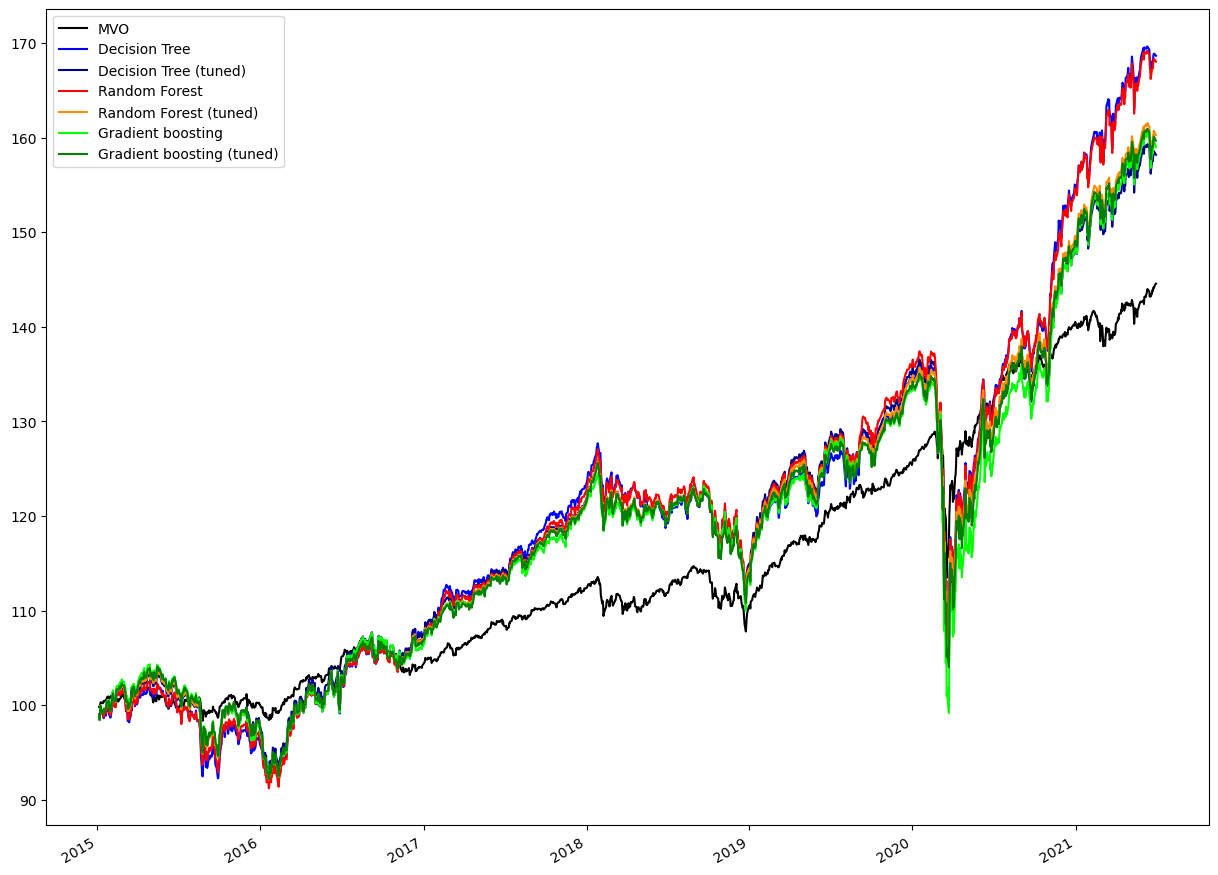

In [110]:
# Plot cumulative returns of different optimizers 
colors = ['black','blue','darkblue','red','darkorange','lime','green']
(1+optimizers_daily_returns).cumprod().mul(100).plot(figsize=(15,12),
                                                    color=colors)
plt.show()

In [97]:
results

,MVO,Decision Tree,Decision Tree (Tuned),Random Forest,Random Forest (Tuned),Gradient boosting,Gradient boosting (Tuned)
Total return,44.57,68.65,58.18,68.03,60.26,59.00,59.67
Annualized return,5.85,8.39,7.32,8.33,7.54,7.41,7.48
Annualized volatility,5.49,9.96,10.02,10.08,9.95,11.22,10.18
Sharpe ratio,0.70,0.64,0.53,0.63,0.56,0.48,0.54


Overall, we can see that the one-time Markowitz optimization did impressively well in maximizing the return per unit of risk (Sharpe ratio) over the period from 2015 to 2021. Amongst the machine learning methods, the decision tree and random forest optimizers show the best sharpe ratio and total return. They also provide a higher total return than the MVO optimizer, however at the expense of higher risk/volatility. Hence, a risk-averse client would prefer the Markowitz portfolio, while a risk-seeking investor might prefer tree-based optimizers. 

#### Asset allocation

In [171]:
# Get average ETF position for each optimizer
average_allocation = pd.concat([MVO_monthly_weights.mean(),predictions_dt.mean(),hyper_predictions_dt.mean(),predictions_rf.mean(),predictions_hyper_rf.mean(),
           predictions_gb.mean(),predictions_hyper_gb.mean()],axis=1)
average_allocation.columns = results.columns
average_allocation

,MVO,Decision Tree,Decision Tree (Tuned),Random Forest,Random Forest (Tuned),Gradient boosting,Gradient boosting (Tuned)
VTI,0.238264,0.110559,0.105308,0.116099,0.104644,0.113560,0.106158
IUSV,0.000899,0.113732,0.107543,0.111792,0.106267,0.112210,0.107723
VBR,0.000000,0.088411,0.101945,0.094517,0.100637,0.097785,0.100202
VEA,0.000000,0.085190,0.096841,0.087563,0.098461,0.098611,0.098872
VWO,0.000000,0.112611,0.097305,0.105600,0.097254,0.095191,0.096190
SHV,0.000000,0.105559,0.099302,0.101387,0.100261,0.098397,0.097948
STIP,0.000000,0.098472,0.105558,0.093326,0.104322,0.103374,0.102882
AGG,0.749658,0.105697,0.102997,0.106438,0.103141,0.110193,0.104682
IBND,0.000000,0.089097,0.088492,0.093136,0.089788,0.091674,0.090320
EMB,0.011178,0.090672,0.094709,0.090141,0.095226,0.097615,0.095653


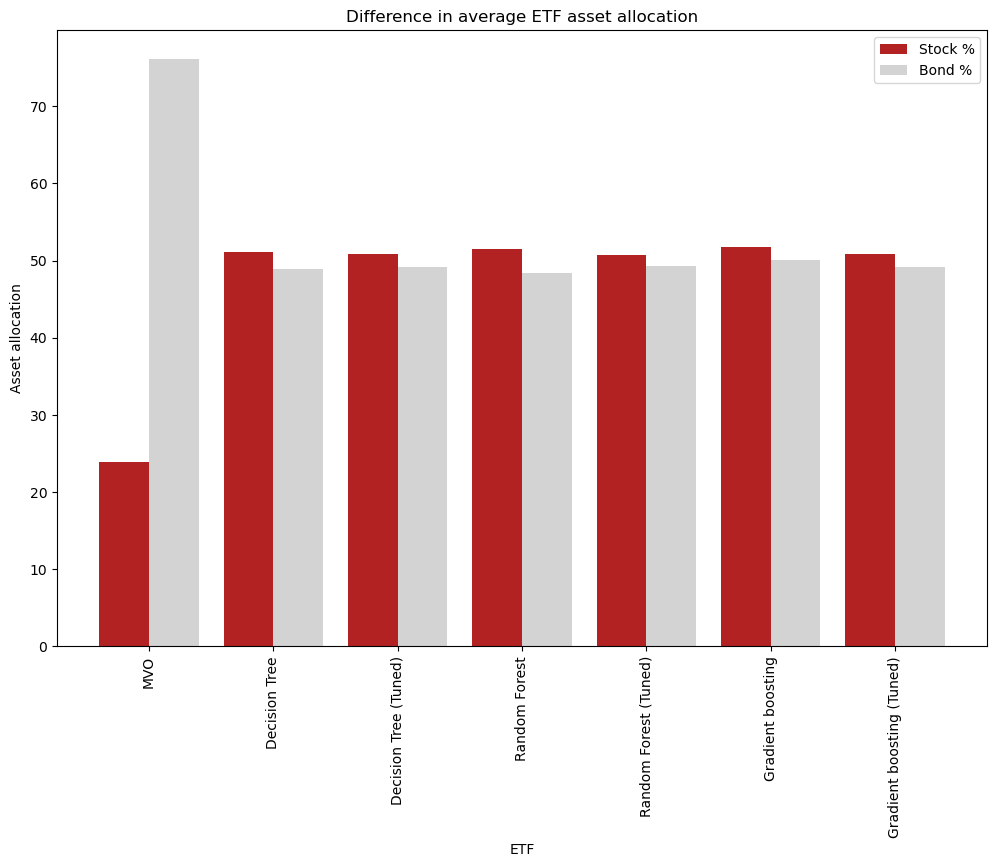

In [181]:
# Plot average stock and bond allocation for each ETF
w = 0.4 
bar1 = np.arange(len(average_allocation.columns))
bar2 = [i+w for i in bar1]

plt.figure(figsize=(12,8))
plt.bar(bar1, average_allocation.iloc[0:5].sum().mul(100), w, label='Stock %', color='firebrick')
plt.bar(bar2, average_allocation.iloc[5:].sum().mul(100), w, label='Bond %',color='lightgrey')
plt.xticks(bar1+w/2,average_allocation.columns,rotation=90)
plt.xlabel('ETF')
plt.ylabel('Asset allocation')
plt.title('Difference in average ETF asset allocation')
plt.legend()
plt.show()

### Zoom into Covid-19

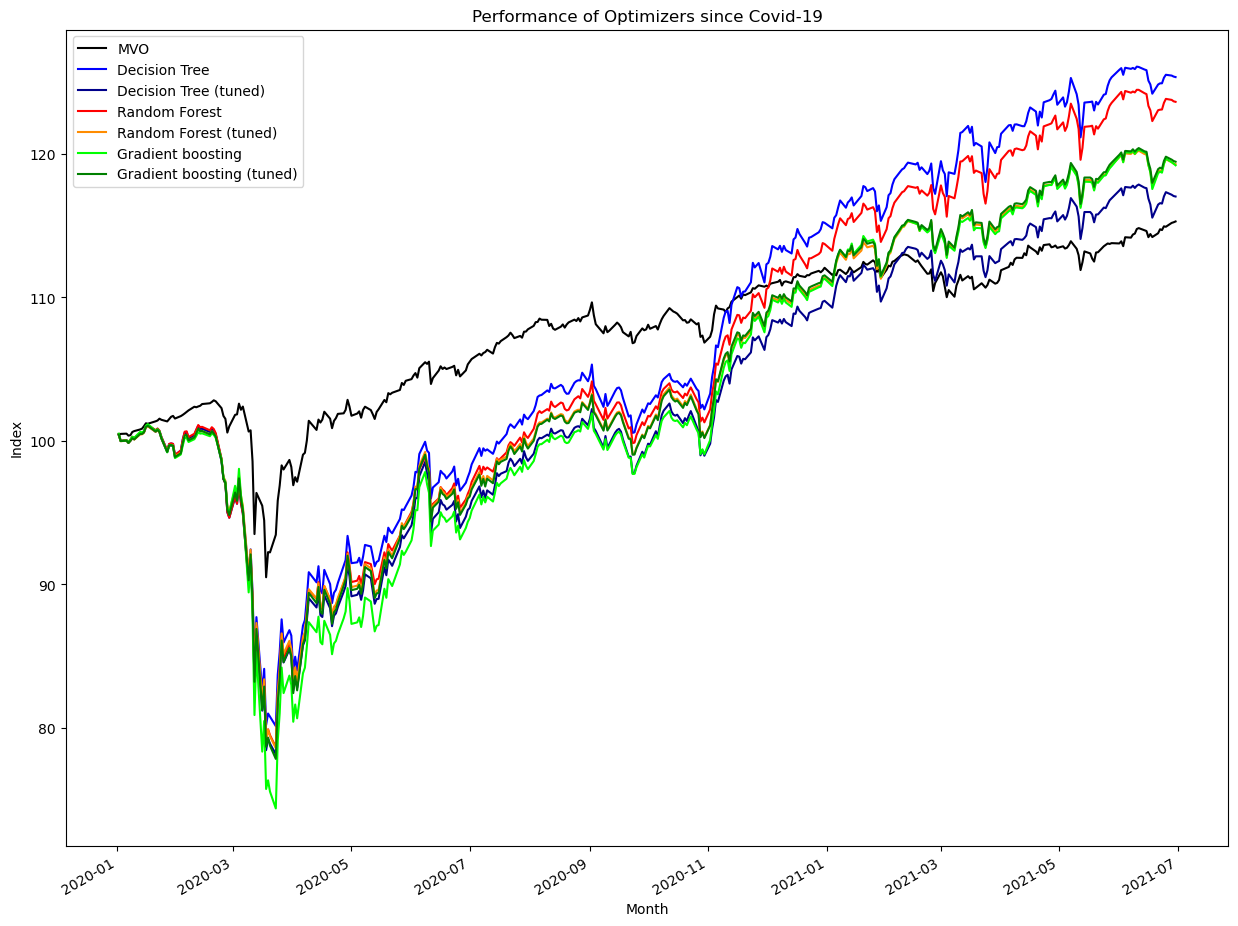

In [117]:
# Plot performance evolution since Covid-19
Covid_cumulative_returns = (1+optimizers_daily_returns.loc['2020-01':]).cumprod().mul(100)
Covid_cumulative_returns.plot(figsize=(15,12),color=colors)
plt.title('Performance of Optimizers since Covid-19')
plt.ylabel('Index')
plt.xlabel('Month')
plt.show()

In [162]:
# Performance and risk during 2020 
performance_risk_covid = pd.DataFrame(index=results.index,columns=results.columns)
for optimizer in results.columns:
    performance_risk_covid[optimizer] = performance_metrics(optimizers_daily_returns.loc['2020':,optimizer])

In [163]:
performance_risk_covid

,MVO,Decision Tree,Decision Tree (Tuned),Random Forest,Random Forest (Tuned),Gradient boosting,Gradient boosting (Tuned)
Total return,15.30,25.36,17.03,23.64,19.29,19.21,19.46
Annualized return,10.00,16.34,11.11,15.27,12.54,12.49,12.65
Annualized volatility,9.15,15.75,16.27,16.22,16.07,19.10,16.61
Sharpe ratio,0.87,0.91,0.56,0.82,0.66,0.55,0.64


In [131]:
# Get maximum drawdowns over March 2020
zoom = Covid_cumulative_returns.loc['2020-02':'2020-04']
max_drawdown = round(((zoom.min()-zoom.max())/zoom.max()).mul(100),2)
max_drawdown

MVO                         -12.03
Decision Tree               -20.73
Decision Tree (tuned)       -22.63
Random Forest               -22.21
Random Forest (tuned)       -22.08
Gradient boosting           -26.08
Gradient boosting (tuned)   -22.83
dtype: float64

In [189]:
# Average ETF allocation during 2020 
average_allocation_2020 =pd.concat([MVO_monthly_weights.loc['2020'].mean(),predictions_dt.loc['2020'].mean(),hyper_predictions_dt.mean(),predictions_rf.loc['2020'].mean(),predictions_hyper_rf.loc['2020'].mean(),
           predictions_gb.loc['2020'].mean(),predictions_hyper_gb.loc['2020'].mean()],axis=1)
average_allocation_2020.columns = results.columns
average_allocation_2020

,MVO,Decision Tree,Decision Tree (Tuned),Random Forest,Random Forest (Tuned),Gradient boosting,Gradient boosting (Tuned)
VTI,0.227162,0.129909,0.105308,0.133490,0.105371,0.113774,0.106892
IUSV,0.000000,0.077860,0.107543,0.081593,0.107563,0.126618,0.115478
VBR,0.000000,0.072276,0.101945,0.075411,0.095672,0.094499,0.097178
VEA,0.000000,0.114921,0.096841,0.106500,0.100526,0.103148,0.101057
VWO,0.000000,0.095004,0.097305,0.098238,0.091181,0.101080,0.091371
SHV,0.000000,0.130805,0.099302,0.112286,0.099978,0.098409,0.094249
STIP,0.000000,0.091241,0.105558,0.096675,0.102435,0.101152,0.098725
AGG,0.772838,0.101323,0.102997,0.097509,0.105008,0.105995,0.104908
IBND,0.000000,0.094522,0.088492,0.097051,0.094594,0.081068,0.092468
EMB,0.000000,0.092139,0.094709,0.101247,0.097673,0.099664,0.097574


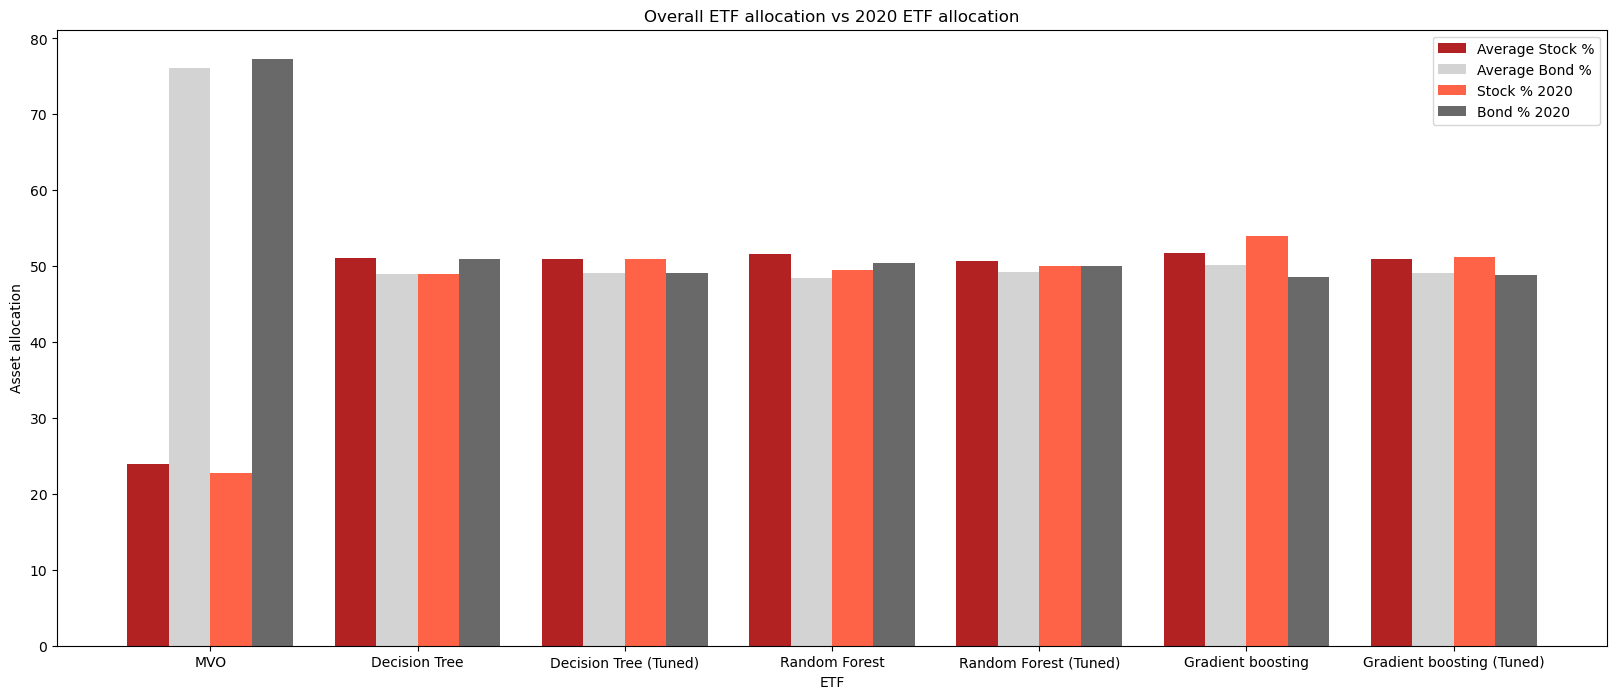

In [196]:
# Plot overall allocation against 2020 allocation
w = 0.2 
bar1 = np.arange(len(average_allocation.columns))
bar2 = [i+w for i in bar1]
bar3 = [i+w for i in bar2]
bar4 = [i+w for i in bar3]

plt.figure(figsize=(20,8))
plt.bar(bar1, average_allocation.iloc[0:5].sum().mul(100), w, label='Average Stock %', color='firebrick')
plt.bar(bar2, average_allocation.iloc[5:].sum().mul(100), w, label='Average Bond %',color='lightgrey')
plt.bar(bar3, average_allocation_2020.iloc[0:5].sum().mul(100), w, label='Stock % 2020', color='tomato')
plt.bar(bar4, average_allocation_2020.iloc[5:].sum().mul(100), w, label='Bond % 2020', color='dimgrey')
plt.xticks(bar1 + 1.5*w,average_allocation.columns)
plt.xlabel('ETF')
plt.ylabel('Asset allocation')
plt.title('Overall ETF allocation vs 2020 ETF allocation')
plt.legend()
plt.show()